In [1]:
# Import necessary modules
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Sklearn imports
from sklearn.model_selection import train_test_split, KFold, cross_validate, ParameterGrid, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.base import clone
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import learning_curve, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                           f1_score, roc_auc_score, confusion_matrix, 
                           classification_report, RocCurveDisplay)

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.3f}'.format)

### LOAD AND CHECK DATA

In [2]:
# Load the data
airline_data = pd.read_csv(r"C:\Users\YILMAZ\Desktop\final_airplane_data.csv")

In [3]:
# Dataset Info
print(f"Shape: {airline_data.shape}")
print(f"Columns: {list(airline_data.columns)}")

Shape: (119255, 22)
Columns: ['satisfaction', 'Customer Type', 'Age', 'Type of Travel', 'Class', 'Flight Distance', 'Seat comfort', 'Departure/Arrival time convenient', 'Food and drink', 'Gate location', 'Inflight wifi service', 'Inflight entertainment', 'Online support', 'Ease of Online booking', 'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service', 'Cleanliness', 'Online boarding', 'Departure Delay Winsorized', 'Arrival Delay Winsorized']


In [4]:
# Data Types
airline_data.dtypes

satisfaction                          object
Customer Type                         object
Age                                    int64
Type of Travel                        object
Class                                 object
Flight Distance                        int64
Seat comfort                           int64
Departure/Arrival time convenient      int64
Food and drink                         int64
Gate location                          int64
Inflight wifi service                  int64
Inflight entertainment                 int64
Online support                         int64
Ease of Online booking                 int64
On-board service                       int64
Leg room service                       int64
Baggage handling                       int64
Checkin service                        int64
Cleanliness                            int64
Online boarding                        int64
Departure Delay Winsorized             int64
Arrival Delay Winsorized             float64
dtype: obj

In [5]:
# First rows
airline_data.head()

,satisfaction,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,Gate location,Inflight wifi service,Inflight entertainment,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay Winsorized,Arrival Delay Winsorized
0,dissatisfied,Loyal Customer,48,Personal Travel,Eco,4001,1,1,1,1,1,1,1,1,4,1,1,4,2,1,16,0.000
1,dissatisfied,Loyal Customer,48,Personal Travel,Eco,3980,1,1,1,1,4,1,4,4,2,3,2,3,2,4,0,0.000
2,dissatisfied,Loyal Customer,40,Personal Travel,Eco,2251,1,1,1,1,1,1,1,1,3,3,2,1,1,1,0,8.000
3,dissatisfied,Loyal Customer,46,Personal Travel,Eco,2453,1,1,1,1,3,1,5,3,1,4,1,2,2,3,3,15.000
4,dissatisfied,Loyal Customer,63,Personal Travel,Eco,2011,1,1,1,1,5,1,5,5,1,5,2,1,2,5,25,25.000


In [6]:
# Missing Values
airline_data.isnull().sum()

satisfaction                         0
Customer Type                        0
Age                                  0
Type of Travel                       0
Class                                0
Flight Distance                      0
Seat comfort                         0
Departure/Arrival time convenient    0
Food and drink                       0
Gate location                        0
Inflight wifi service                0
Inflight entertainment               0
Online support                       0
Ease of Online booking               0
On-board service                     0
Leg room service                     0
Baggage handling                     0
Checkin service                      0
Cleanliness                          0
Online boarding                      0
Departure Delay Winsorized           0
Arrival Delay Winsorized             0
dtype: int64

In [7]:
# Target Variable Distribution
target_dist = airline_data["satisfaction"].value_counts(normalize = True) * 100   # value_counts() counts each unique value; normalize=True gives proportions instead of counts.
print(target_dist)

satisfaction
satisfied      54.144
dissatisfied   45.856
Name: proportion, dtype: float64


In [8]:
# values of categorical variables
categorical_cols = airline_data.select_dtypes(include=["object", "category"]).columns
for col in categorical_cols:
    print(airline_data[col].unique())

['dissatisfied' 'satisfied']
['Loyal Customer' 'disloyal Customer']
['Personal Travel' 'Business travel']
['Eco' 'Business' 'Eco Plus']


One-Hot encoding should applied because there is no natural ordering among categorical variables.

### TRAIN-TEST SPLIT

In [9]:
# Separate features and target
X = airline_data.drop("satisfaction", axis = 1)
y = airline_data["satisfaction"]

# Split the data (%80 train and %20 test)
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train_raw.shape[0]} samples")
print(f"Testing set size: {X_test_raw.shape[0]} samples")
print(f"\nTarget distribution in training set:")
print(y_train.value_counts(normalize=True))
print(f"\nTarget distribution in testing set:")
print(y_test.value_counts(normalize=True))

Training set size: 95404 samples
Testing set size: 23851 samples

Target distribution in training set:
satisfaction
satisfied      0.541
dissatisfied   0.459
Name: proportion, dtype: float64

Target distribution in testing set:
satisfaction
satisfied      0.541
dissatisfied   0.459
Name: proportion, dtype: float64


### PREPROCESSING PIPELINE

In [10]:
def preprocess_for_lr_ohe(X_train, X_test, drop_first=True):
    """
    Preprocess data for Logistic Regression using:
    - One-Hot Encoding for categorical variables
    - Standard Scaling for numerical variables
    - Leakage-safe: fit ONLY on training data
    """

    # Identify columns
    categorical_cols = X_train.select_dtypes(include=["object"]).columns.tolist()
    numerical_cols = X_train.select_dtypes(exclude=["object"]).columns.tolist()

    # Numeric pipeline (scale only numeric)
    numeric_transformer = Pipeline(steps=[
        ("scaler", StandardScaler())
    ])

    # Categorical pipeline (one-hot)
    categorical_transformer = Pipeline(steps=[
        ("onehot", OneHotEncoder(
            drop="first" if drop_first else None,
            handle_unknown="ignore",
            sparse_output=False
        ))
    ])

    # Combine transformations
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numerical_cols),
            ("cat", categorical_transformer, categorical_cols)
        ],
        remainder="drop"
    )

    # Fit ONLY on training, transform both
    X_train_arr = preprocessor.fit_transform(X_train)
    X_test_arr = preprocessor.transform(X_test)

    # Build feature names
    cat_feature_names = []
    if len(categorical_cols) > 0:
        cat_feature_names = list(
            preprocessor.named_transformers_["cat"]
            .named_steps["onehot"]
            .get_feature_names_out(categorical_cols)
        )

    feature_names = numerical_cols + cat_feature_names

    # Convert to DataFrame
    X_train_final = pd.DataFrame(
        X_train_arr, columns=feature_names, index=X_train.index
    )
    X_test_final = pd.DataFrame(
        X_test_arr, columns=feature_names, index=X_test.index
    )

    return X_train_final, X_test_final, preprocessor
    

# TARGET ENCODING
le_target = LabelEncoder()
y_train_encoded = le_target.fit_transform(y_train)
y_test_encoded = le_target.transform(y_test)

class_names = le_target.classes_.tolist()

print(f"Target encoding: {dict(zip(le_target.classes_, le_target.transform(le_target.classes_)))}")

Target encoding: {'dissatisfied': 0, 'satisfied': 1}


### HYPERPARAMETER TUNING WITH CROSS-VALIDATION

In [11]:
categorical_cols = X_train_raw.select_dtypes(include=["object"]).columns.tolist()
numerical_cols   = X_train_raw.select_dtypes(exclude=["object"]).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(
        drop="first",                 # drop_first=True behavior
        handle_unknown="ignore",
        sparse_output=False
    ))
])

preprocessor_cv = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_cols),
        ("cat", categorical_transformer, categorical_cols)
    ],
    remainder="drop"
)

# PIPELINE 
pipe = Pipeline(steps=[
    ("prep", preprocessor_cv),  # we shouldn't use a previously-fitted preprocessor
    ("clf", LogisticRegression(random_state=42))
])

# C: inverse of regularization strength
param_grid = {
    "clf__C": [0.01, 0.1, 1, 10, 100],
    "clf__penalty": ["l2"],
    "clf__solver": ["lbfgs"],
    "clf__max_iter": [1000],  # Increased to ensure convergence
}

# Stratified K-Fold preserves class distribution in each fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Grid Search with ROC-AUC scoring
gs = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="roc_auc",   # Threshold-independent metric
    cv=cv,
    n_jobs=-1
)

# Fit on RAW training data 
gs.fit(X_train_raw, y_train_encoded)

# Best cross validation results
print("Best CV ROC-AUC:", gs.best_score_)
print("Best hyperparameters:", gs.best_params_)

# Final model evaluation on the test set
final_lr = gs.best_estimator_

y_test_pred  = final_lr.predict(X_test_raw)
y_test_proba = final_lr.predict_proba(X_test_raw)[:, 1]

Best CV ROC-AUC: 0.9368755595291974
Best hyperparameters: {'clf__C': 0.1, 'clf__max_iter': 1000, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}


- Categorical and numerical variables were automatically detected.

- StandardScaler was applied to numerical variables.

- One-Hot Encoding was applied to categorical variables (drop_first=True).

- All transformations were combined using ColumnTransformer.

- Preprocessing was only fitted to the training data (no data leakage).

- Training and test data were transformed separately.

- Names were generated for all generated features.

- Numpy outputs were converted to DataFrame.

- The target variable was converted to 0-1 using LabelEncoder.

- Target encoding was only fitted in the training data, and transformed in the testing data.

### COMPREHENSIVE EVALUATION

In [12]:
print(classification_report(y_test_encoded, y_test_pred, target_names=class_names))

              precision    recall  f1-score   support

dissatisfied       0.86      0.84      0.85     10937
   satisfied       0.86      0.88      0.87     12914

    accuracy                           0.86     23851
   macro avg       0.86      0.86      0.86     23851
weighted avg       0.86      0.86      0.86     23851



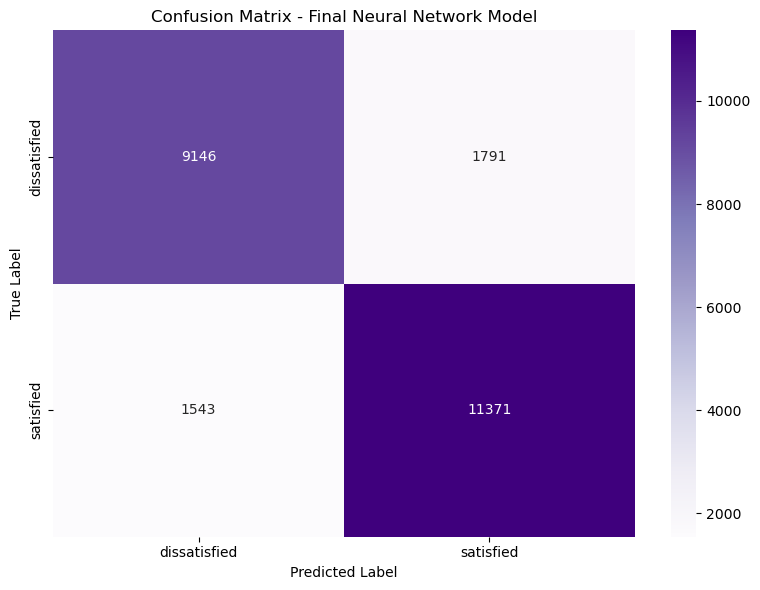

In [13]:
# Confusion Matrix
cm = confusion_matrix(y_test_encoded, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Final Neural Network Model')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

- 9146 genuinely dissatisfied individuals were correctly predicted.

- 11371 genuinely satisfied individuals were correctly predicted.

- 1791 dissatisfied individuals (incorrectly predicted satisfied)

- 1543 satisfied individuals (incorrectly predicted dissatisfied)

The error numbers are balanced between the two classes. The model did not lean towards a single class.

AUC Score: 0.9374


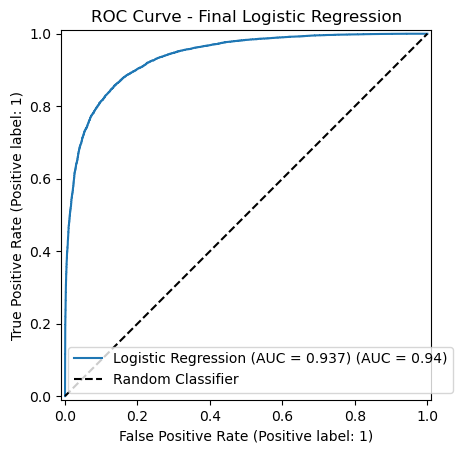

In [14]:
# Predict probabilities using RAW test data (because final_lr is a Pipeline)
y_test_proba = final_lr.predict_proba(X_test_raw)[:, 1]

# AUC
auc_score = roc_auc_score(y_test_encoded, y_test_proba)
print(f"AUC Score: {auc_score:.4f}")

# ROC curve
RocCurveDisplay.from_estimator(
    final_lr,               # Pipeline (prep + clf)
    X_test_raw,             # RAW data
    y_test_encoded,
    name=f"Logistic Regression (AUC = {auc_score:.3f})"
)

plt.plot([0, 1], [0, 1], "k--", label="Random Classifier")
plt.title("ROC Curve - Final Logistic Regression")
plt.legend()
plt.show()

The model has a very strong distinctiveness.

### Model Coefficients (The LR version of Feature Importance)

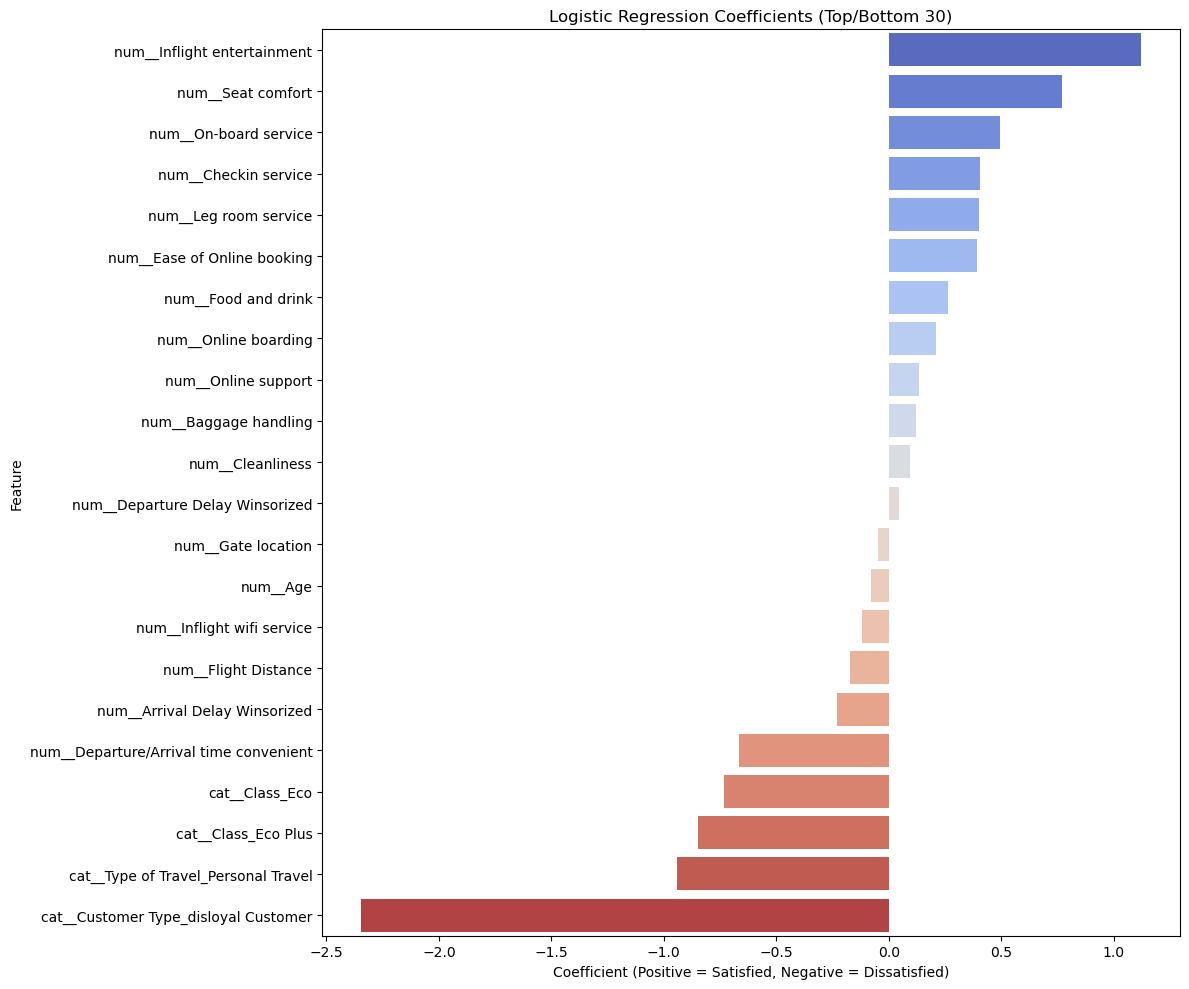

In [15]:
# Extract the trained Logistic Regression model from the pipeline
lr_model = final_lr.named_steps["clf"]

# Get coefficients (for binary classification: shape = (1, n_features))
coefficients = lr_model.coef_.ravel()

# Get the feature names AFTER preprocessing (includes one-hot encoded names)
feature_names = final_lr.named_steps["prep"].get_feature_names_out()

# Build a dataframe and sort by coefficient
coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coefficients
}).sort_values("Coefficient", ascending=False)

# Show only top/bottom features to keep plot readable
top_n = 30
coef_plot_df = pd.concat([coef_df.head(top_n), coef_df.tail(top_n)])

# Plot
plt.figure(figsize=(12, 10))
sns.barplot(x="Coefficient", y="Feature", data=coef_plot_df, palette="coolwarm")
plt.title(f"Logistic Regression Coefficients (Top/Bottom {top_n})")
plt.xlabel("Coefficient (Positive = Satisfied, Negative = Dissatisfied)")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [16]:
print("\nTop Positive Drivers of Satisfaction:")
print(coef_df.head(7))


Top Positive Drivers of Satisfaction:
                        Feature  Coefficient
7   num__Inflight entertainment        1.122
2             num__Seat comfort        0.772
10        num__On-board service        0.493
13         num__Checkin service        0.407
11        num__Leg room service        0.402
9   num__Ease of Online booking        0.390
4           num__Food and drink        0.264


In [17]:
print("\nTop Negative Drivers of Satisfaction:")
print(coef_df.tail(7))


Top Negative Drivers of Satisfaction:
                                   Feature  Coefficient
1                     num__Flight Distance       -0.174
17           num__Arrival Delay Winsorized       -0.229
3   num__Departure/Arrival time convenient       -0.664
20                          cat__Class_Eco       -0.732
21                     cat__Class_Eco Plus       -0.849
19     cat__Type of Travel_Personal Travel       -0.942
18    cat__Customer Type_disloyal Customer       -2.346


- There is no dominance among the coefficients.

- Inflight entertainment and seat comfort are the strongest indicators of satisfaction.

- On-board, check-in, and legroom services significantly support satisfaction.

- Disloyal customers are the strongest predictor of dissatisfaction.

- Personal travel and economy classes are associated with lower satisfaction.

- Timing issues and delays significantly reduce satisfaction.

### PERFORMANCE VALIDATION & OVERFITTING DETECTION

Overfitting Analysis
------------------------------
Training Accuracy: 0.860236
Testing Accuracy:  0.860216
Difference:        0.000021
------------------------------
Training AUC:      0.9370
Testing AUC:       0.9374
Difference:        0.0004


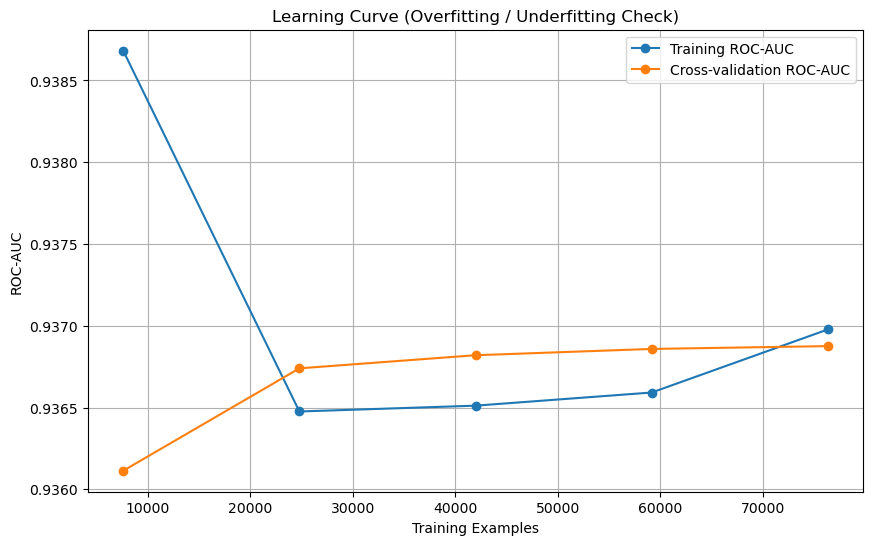

In [18]:
# Predictions
y_train_pred = final_lr.predict(X_train_raw)
y_test_pred  = final_lr.predict(X_test_raw)

# Accuracy
train_acc = accuracy_score(y_train_encoded, y_train_pred)
test_acc  = accuracy_score(y_test_encoded, y_test_pred)

# Probabilities for AUC
y_train_proba = final_lr.predict_proba(X_train_raw)[:, 1]
y_test_proba  = final_lr.predict_proba(X_test_raw)[:, 1]

train_auc = roc_auc_score(y_train_encoded, y_train_proba)
test_auc  = roc_auc_score(y_test_encoded, y_test_proba)

print("Overfitting Analysis")
print("-" * 30)
print(f"Training Accuracy: {train_acc:.6f}")
print(f"Testing Accuracy:  {test_acc:.6f}")
print(f"Difference:        {abs(train_acc - test_acc):.6f}")
print("-" * 30)
print(f"Training AUC:      {train_auc:.4f}")
print(f"Testing AUC:       {test_auc:.4f}")
print(f"Difference:        {abs(train_auc - test_auc):.4f}")

# Learning Curve 
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

train_sizes, train_scores, val_scores = learning_curve(
    estimator=final_lr,            # tuned Pipeline (prep + clf)
    X=X_train_raw,                 # RAW data
    y=y_train_encoded,
    cv=cv,
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5),
    scoring="roc_auc"              # more robust than accuracy
)

train_mean = train_scores.mean(axis=1)
val_mean   = val_scores.mean(axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, "o-", label="Training ROC-AUC")
plt.plot(train_sizes, val_mean, "o-", label="Cross-validation ROC-AUC")
plt.title("Learning Curve (Overfitting / Underfitting Check)")
plt.xlabel("Training Examples")
plt.ylabel("ROC-AUC")
plt.legend(loc="best")
plt.grid(True)
plt.show()

- No overfitting is observed: Training and testing accuracy (0.8602) and ROC-AUC scores (~0.937) are almost identical, indicating excellent generalization performance.

- Stable learning behavior: The learning curve shows that training and cross-validation ROC-AUC values quickly converge and remain close as the training size increases, suggesting a well-balanced bias–variance trade-off.

- Strong discriminative power: Despite moderate accuracy, the high ROC-AUC demonstrates that the model separates satisfied and dissatisfied customers very effectively, and performance is not sensitive to data size.

In [19]:
duplicate_count = airline_data.duplicated().sum()
print(f"Total duplicate row: {duplicate_count}")

Total duplicate row: 0


- There is no way to artificially improve model performance.

- A positive control in terms of data leakage risk.

### Overfitting
- No evidence of overfitting is observed.
- The difference between training and testing accuracy is approximately zero.
- The difference between training and testing ROC-AUC is also approximately zero.
- From the learning curve analysis:
  - Training and cross-validation curves are very close to each other.
  - Model performance remains stable as the training sample size increases.
- This indicates that the model does not memorize the training data and generalizes well to unseen data.


### Data Leakage
- No signs of data leakage are detected.
- Preprocessing steps:
  - StandardScaler and OneHotEncoder are fitted only on the training data.
  - The test data is transformed using the fitted preprocessing objects.
- Target encoding:
  - LabelEncoder is fitted only on the training target variable.
- Cross-validation:
  - StratifiedKFold is used appropriately, preserving class distributions across folds.
- Duplicate observations:
  - No duplicate rows are present in the dataset.
- The very similar training and testing performance:
  - Is not an indicator of data leakage.
  - Is expected for a large, clean, and well-structured dataset.